In [2]:
%pip install shapely geopandas rasterio

Defaulting to user installation because normal site-packages is not writeable
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 692.6 kB/s eta 0:00:02
   ------------ --------------------------- 0.5/1.7 MB 692.6 kB/s eta 0:00:02
   ------------------------ --------------- 1.0/1.7 MB 914.7 kB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.3 MB/s  0:00:01
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   - -------------------------------------- 0.8/25.4 MB 5.2 MB/s eta 0:00:05
   -- ------------------------------------- 1.8/25.4 MB 5.5 MB/s eta 0:00:05
   --- ------------------------------------ 2.4/25.4 

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import rasterio
import random

In [2]:
import pandas as pd
import numpy as np

# Load dataset
file_name = "presence_dataset_real_presences.csv"
df_presence = pd.read_csv(file_name)

# =====================================================
# 1. Define Parameters and Calculate Ranges
# =====================================================
N_presence = len(df_presence)
N_absence_total = N_presence * 2  # 2× absence for better balance

# Split absences across 3 categories
N_A = int(N_absence_total * 0.4)  # 40% broad background
N_B = int(N_absence_total * 0.4)  # 40% restricted (unfavorable env)
N_C = N_absence_total - N_A - N_B  # 20% ecologically impossible

cols_for_range = ['decimalLatitude', 'decimalLongitude', 'bathymetry',
                  'sst', 'sss', 'shoredistance', 'date_year', 'month']

stats = df_presence[cols_for_range].agg(['min', 'max']).T

np.random.seed(42)

# =====================================================
# 2. Type A: Broad Background (within real observed range)
# =====================================================
df_A = pd.DataFrame()
for col in cols_for_range:
    df_A[col] = np.random.uniform(stats.loc[col, 'min'],
                                  stats.loc[col, 'max'], N_A)

# =====================================================
# 3. Type B: Environmentally Restricted (unsuitable SST/SSS)
# =====================================================
df_B = pd.DataFrame()

cols_random = ['decimalLatitude', 'decimalLongitude', 'bathymetry',
               'shoredistance', 'date_year', 'month']
for col in cols_random:
    df_B[col] = np.random.uniform(stats.loc[col, 'min'],
                                  stats.loc[col, 'max'], N_B)

# Unsuitable SST: < 18°C or > 34°C (outside ideal 21–30°C)
sst_cold = np.random.uniform(-2, 18, N_B // 2)  # cold oceans / subpolar
sst_hot = np.random.uniform(34, 45, N_B - N_B // 2)
df_B['sst'] = np.concatenate([sst_cold, sst_hot])
np.random.shuffle(df_B['sst'].values)

# Unsuitable SSS: < 30 ppt (brackish) or > 40 ppt (hypersaline)
sss_low = np.random.uniform(0, 30, N_B // 2)
sss_high = np.random.uniform(40, 45, N_B - N_B // 2)
df_B['sss'] = np.concatenate([sss_low, sss_high])
np.random.shuffle(df_B['sss'].values)

# =====================================================
# 4. Type C: Ecologically Impossible Regions
# =====================================================
df_C = pd.DataFrame()

# Latitude outside tropical range
lat_cold = np.random.uniform(-80, -40, N_C // 2)
lat_polar = np.random.uniform(40, 80, N_C - N_C // 2)
df_C['decimalLatitude'] = np.concatenate([lat_cold, lat_polar])

# Longitude any valid range
df_C['decimalLongitude'] = np.random.uniform(-180, 180, N_C)

# Unrealistic bathymetry (very deep abyssal zones)
df_C['bathymetry'] = np.random.uniform(2000, 8000, N_C)  # depth in meters

# Extreme SST (freezing or boiling — not physically valid but clear negatives)
df_C['sst'] = np.random.choice(
    np.concatenate([
        np.random.uniform(-5, 5, N_C // 2),  # frozen seas
        np.random.uniform(40, 100, N_C - N_C // 2)  # unrealistically hot
    ]),
    N_C, replace=False)

# Extreme salinity (impossible)
df_C['sss'] = np.random.choice(
    np.concatenate([
        np.random.uniform(0, 10, N_C // 2),
        np.random.uniform(45, 60, N_C - N_C // 2)
    ]),
    N_C, replace=False)

# Far from shore or random
df_C['shoredistance'] = np.random.uniform(1000, 10000, N_C)  # km from coast
df_C['date_year'] = np.random.randint(1980, 2025, N_C)
df_C['month'] = np.random.randint(1, 13, N_C)

# =====================================================
# 5. Combine all absence types
# =====================================================
df_abs = pd.concat([df_A, df_B, df_C], ignore_index=True)
df_abs['presence'] = 0

# Round integer fields
for col in ['shoredistance', 'date_year', 'month']:
    df_abs[col] = df_abs[col].round().astype(int)

# Add missing fields
df_abs['catalogNumber'] = np.nan
df_abs['eventDate'] = 'Pseudo-Absence'
df_abs['behavior'] = np.nan
df_abs['sex'] = np.nan
df_abs['id'] = [f'pseudo_abs_{i}' for i in range(len(df_abs))]

# Reorder columns
df_abs = df_abs[df_presence.columns]

# =====================================================
# 6. Merge with presence data
# =====================================================
df_presence['presence'] = 1
df_final = pd.concat([df_presence, df_abs], ignore_index=True)

output_filename = "shark_presence_absence_refined_v2.csv"
df_final.to_csv(output_filename, index=False)

# =====================================================
# 7. Summary
# =====================================================
print(f"Presence records: {len(df_presence)}")
print(f"Absence records: {len(df_abs)} (A={N_A}, B={N_B}, C={N_C})")
print(f"Combined total: {len(df_final)}")
print("\nSample of extreme (Type C) absence points:")
print(df_C[['decimalLatitude','sst','sss','bathymetry']].head())
print(f"\nSaved: {output_filename}")


Presence records: 8408
Absence records: 16816 (A=6726, B=6726, C=3364)
Combined total: 25224

Sample of extreme (Type C) absence points:
   decimalLatitude        sst        sss   bathymetry
0       -61.730804  61.518868  55.947960  3903.821531
1       -46.686467   4.377898  52.531484  6222.327651
2       -51.832458  -3.025343  57.729353  4448.354137
3       -77.640263  61.053244  51.358276  3528.241985
4       -71.088197  -3.576075   1.100157  2101.639208

Saved: shark_presence_absence_refined_v2.csv


### Earth data

# Model building and training

## Using XGBoost classifier

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("shark_presence_absence_refined_v2.csv")

In [11]:
df.columns

Index(['catalogNumber', 'decimalLatitude', 'decimalLongitude', 'eventDate',
       'month', 'date_year', 'bathymetry', 'sst', 'sss', 'shoredistance',
       'behavior', 'sex', 'id', 'presence'],
      dtype='object')

In [12]:
input_cols = [
    "decimalLatitude",
    "decimalLongitude",
    "month",
    "bathymetry",
    "sst",
    "sss",
    "shoredistance"
]
X = df[input_cols]

In [13]:
X.head()

,decimalLatitude,decimalLongitude,month,bathymetry,sst,sss,shoredistance
0,-23.03220,113.71500,5.0,55.0,24.90,34.86,10835
1,-21.90130,113.90150,4.0,82.0,25.74,34.82,7200
2,3.46845,72.80718,5.0,165.0,29.03,34.95,1425
3,-23.97360,35.51220,2.0,2.0,25.61,34.86,585
4,12.93330,123.53300,4.0,33.0,28.24,32.56,339


In [14]:
y = df["presence"]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train

,decimalLatitude,decimalLongitude,month,bathymetry,sst,sss,shoredistance
14747,-11.749216,37.292392,6.0,1734.637670,29.233438,27.208955,629018
10163,32.348215,-88.309741,6.0,3610.235158,24.044574,34.059692,567619
19652,4.027621,-7.220681,4.0,1641.736674,43.627719,43.383585,1275085
12169,26.647401,156.601876,6.0,-1461.761586,16.488712,37.845537,1070674
11526,-14.993133,-135.407407,1.0,351.633790,23.162689,31.543211,863594
...,...,...,...,...,...,...,...
21575,-6.856437,118.153455,8.0,2652.270535,42.154278,9.506434,963789
5390,-20.550190,116.516690,12.0,12.000000,26.300000,34.170000,2244
860,12.933300,123.533000,4.0,33.000000,28.240000,32.560000,339
15795,29.146401,81.017764,3.0,-1309.145213,2.748227,12.420741,680355


In [17]:
y_train

14747    0
10163    0
19652    0
12169    0
11526    0
        ..
21575    0
5390     1
860      1
15795    0
23654    0
Name: presence, Length: 20179, dtype: int64

In [18]:
from xgboost import XGBClassifier
 
# Initialize XGBClassifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model to training data
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
X_train.head(5)

,decimalLatitude,decimalLongitude,month,bathymetry,sst,sss,shoredistance
14747,-11.749216,37.292392,6.0,1734.637670,29.233438,27.208955,629018
10163,32.348215,-88.309741,6.0,3610.235158,24.044574,34.059692,567619
19652,4.027621,-7.220681,4.0,1641.736674,43.627719,43.383585,1275085
12169,26.647401,156.601876,6.0,-1461.761586,16.488712,37.845537,1070674
11526,-14.993133,-135.407407,1.0,351.633790,23.162689,31.543211,863594


In [20]:
y_test.head(5)

9069     0
971      1
18528    0
5061     1
963      1
Name: presence, dtype: int64

In [21]:
X_test.head()

,decimalLatitude,decimalLongitude,month,bathymetry,sst,sss,shoredistance
9069,48.179260,170.375309,7.0,1965.528667,22.147854,29.316837,404148
971,-21.901300,113.901500,7.0,82.000000,25.740000,34.820000,7200
18528,33.067508,100.798355,3.0,-1278.143285,8.373296,15.256053,1247102
5061,-21.901300,113.901500,4.0,82.000000,25.740000,34.820000,7200
963,-21.901300,113.901500,6.0,82.000000,25.740000,34.820000,7200


In [22]:
model.predict([[-23.03220, 113.715000, 12.0, 4111.000000, 200.900000, 100.860000, 10835]])

array([0])

In [23]:
y_pred = model.predict(X_test)
print(y_pred[:5])

[0 1 0 1 1]


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost model: {accuracy:.4f}")

Accuracy of the XGBoost model: 0.9982


In [25]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9982160555004955

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3326
           1       1.00      1.00      1.00      1719

    accuracy                           1.00      5045
   macro avg       1.00      1.00      1.00      5045
weighted avg       1.00      1.00      1.00      5045


Confusion Matrix:
 [[3321    5]
 [   4 1715]]


In [26]:
import matplotlib.pyplot as plt

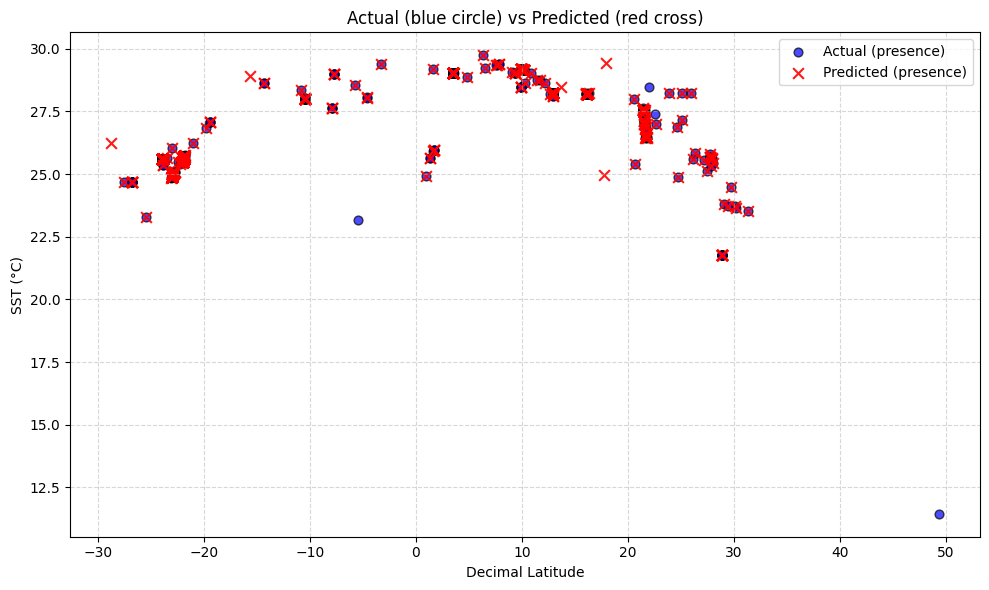

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try to build a plotting DataFrame from variables already in the notebook; otherwise reload CSV
try:
    plot_df
except NameError:
    try:
        # Prefer test split data if available
        plot_df = X_test[['decimalLatitude', 'sst']].copy()
        plot_df['Actual'] = y_test.values
        # try to use existing predictions if present
        if 'y_pred' in globals():
            plot_df['Prediction'] = y_pred
        elif 'y_pred_rf' in globals():
            plot_df['Prediction'] = y_pred_rf
        elif 'rf_model' in globals():
            plot_df['Prediction'] = rf_model.predict(X_test)
        elif 'model' in globals():
            plot_df['Prediction'] = model.predict(X_test)
        else:
            # fall back to using the model to predict
            plot_df['Prediction'] = np.zeros(len(plot_df), dtype=int)
    except Exception:
        # Reload full CSV and try to reconstruct
        df_plot_source = pd.read_csv('shark_presence_absence_refined.csv')
        plot_df = df_plot_source[['decimalLatitude', 'sst']].copy()
        plot_df['Actual'] = df_plot_source['presence']
        # If a model exists, predict on available predictors
        try:
            predictor_cols = [
                'decimalLatitude', 'decimalLongitude', 'date_year', 'month',
                'bathymetry', 'sst', 'sss', 'shoredistance'
            ]
            X_all = df_plot_source[predictor_cols].copy()
            # simple imputation if necessary
            if X_all['sst'].isnull().any() and 'sst_impute_value' in globals():
                X_all['sst'] = X_all['sst'].fillna(sst_impute_value)
            if 'rf_model' in globals():
                plot_df['Prediction'] = rf_model.predict(X_all)
            elif 'model' in globals():
                # model may expect fewer columns
                cols_for_model = [c for c in predictor_cols if c in X.columns]
                plot_df['Prediction'] = model.predict(X_all[cols_for_model])
            else:
                plot_df['Prediction'] = np.zeros(len(plot_df), dtype=int)
        except Exception:
            plot_df['Prediction'] = np.zeros(len(plot_df), dtype=int)

# Now create overlay scatter: Actual = blue circle (o), Predicted = red cross (x)
plt.figure(figsize=(10, 6))

# Actual presence points (blue circle)
actual_pts = plot_df[plot_df['Actual'] == 1]
plt.scatter(
    actual_pts['decimalLatitude'],
    actual_pts['sst'],
    c='blue',
    marker='o',
    s=40,
    alpha=0.7,
    edgecolors='k',
    label='Actual (presence)'
)

# Predicted presence points (red cross)
pred_pts = plot_df[plot_df['Prediction'] == 1]
plt.scatter(
    pred_pts['decimalLatitude'],
    pred_pts['sst'],
    c='red',
    marker='x',
    s=60,
    alpha=0.9,
    linewidths=1.5,
    label='Predicted (presence)'
)

plt.xlabel('Decimal Latitude')
plt.ylabel('SST (°C)')
plt.title('Actual (blue circle) vs Predicted (red cross)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig('actual_vs_predicted_overlay.png', dpi=200)
plt.show()


In [31]:
import pickle

# 2. Save the trained model to a .pkl file
filename = 'presence_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model successfully saved to {filename}")

Model successfully saved to presence_model.pkl


In [34]:
import pickle 

filename = './presence_model.pkl'    
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)
    
loaded_model.predict([[-23.03220, 113.715000, 12.0, 4111.000000, 200.900000, 100.860000, 10835]])

array([0])

## Random Forest Classifier
### Using K-fold cross validation

In [28]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)


cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)



In [29]:
cv_scores

array([0.99821606, 0.99801784, 0.99841427, 0.99821606, 0.99900872])

In [30]:
X_train.head()

,decimalLatitude,decimalLongitude,month,bathymetry,sst,sss,shoredistance
14747,-11.749216,37.292392,6.0,1734.637670,29.233438,27.208955,629018
10163,32.348215,-88.309741,6.0,3610.235158,24.044574,34.059692,567619
19652,4.027621,-7.220681,4.0,1641.736674,43.627719,43.383585,1275085
12169,26.647401,156.601876,6.0,-1461.761586,16.488712,37.845537,1070674
11526,-14.993133,-135.407407,1.0,351.633790,23.162689,31.543211,863594
